# A Statistical Analysis of Smart Scale Projects in Virginia

#### Christopher Garcia, University of Mary Washington

## I. Introduction

The Virginia Smart Scale methodology was finalized in November 2017 in order to provide an objective scoring system for the state's transportation projects competing for funding. The complete technical specification of the Smart Scale methodology can be found in the November 2017 technical guide, found here: [http://vasmartscale.org/documents/20171115/ss_technical_guide_nov13_2017.pdf](http://vasmartscale.org/documents/20171115/ss_technical_guide_nov13_2017.pdf).

The purpose of this analysis is to 1) provide some descriptive statistics of recently funded projects, and 2) to independently assess whether the Smart Scale scores (SSS) assigned to these projects were consistent with the Smart Scale methodology specified in the technical guide. This analysis uses a dataset provided by the Fredericksburg Area Metropolitan Planning Organization (FAMPO), containing data on 404 projects. This analysis uses the R statistical computing environment within a Jupyter notebook. This allows the analysis to be both explained as well as executed and allows complete transparancy of the analytical methodology. This removes any ambiguity and also guarantees reproducibility of the results.

## II. Data Inspection and Preparation

The data was provided in a Microsoft Excel spreadsheet. This was first converted to a CSV file (ss-data.csv) and then a number of transformation processes were applied to clean and scale the data as well as to impute missing values. To begin, we first define several functions which will be used in the data transformation:

In [159]:
# Turn off verbose output messages.
options(warn=0)

# Include all libraries that will be used in this notebook's code
library(restriktor) # Used for constrained regression
library(ggplot2)
library(gridExtra)

# Given a vector, a vector of original values, and a corresponding vector of 
# replacement values, apply the replacements and return the transformed vector.
recode <- function(vec, from.vals, to.vals) {
    f = function(v) {
        for(i in 1:length(from.vals)) {
            if(v == from.vals[i]) { return(to.vals[i]) }
        }
        return(v)
    }
    return(sapply(as.vector(vec), f))
}

# Function for imputing mean of a vector to its missing values.
impute.mean <- function(vec) {
    vec[is.na(vec)] = mean(vec, na.rm=TRUE)
    vec
}

# Function for imputing value of 0 to each missing value in the vector.
impute.0 <- function(vec) {
    vec[is.na(vec)] = 0
    vec
}

Next we read in the dataset and inspect the first few rows of data:

In [160]:
data <- read.csv('ss-data.csv')
head(data)

App.Id,Area.Type,District,Organization.Name,Project.Title,Statewide.High.Priority,District.Grant,Throughput.Score,Delay.Score,Crash.Frequency.Score,...,Travel.Time.Reliability.Score,Land.Use.Score,Project.Benefit.Score,Total.Project,Score.Divided.by.Total.Cost,SMART.SCALE.Request,SMART.SCALE.Score,Benefit.Rank,State.Rank,District.Rank
1414,A,NOVA,Northern Virginia Transportation Commission,VRE Fredericksburg Line Capacity Expansion,x,,17.69,87.66,100,...,-,64.016,64.236,216034920,2.973,92636120,6.934,1,109,16
1057,A,Hampton Roads,Hampton Roads Transportation Planning Organization,I-64 Southside Widening and High Rise Bridge - Phase 1,x,,100,88.96,45.16,...,29.044,10.464,62.042,600000000,1.034,100000000,6.204,2,120,22
1090,A,Hampton Roads,Hampton Roads Transportation Planning Organization,I-64/I-264 Interchange Improvements,x,,60.61,53.86,-,...,24.245,31.671,48.747,350091800,1.392,50000000,9.749,3,79,18
1293,A,NOVA,Prince William County,Route 234 At Balls Ford Intrchng and Rel/Widen Balls Ford Rd,x,x,65.48,100,15.61,...,1.05,-,41.289,126027000,3.276,124027000,3.329,4,170,30
1249,A,NOVA,Fairfax County,VA 286 - Popes Head Road Interchange,x,x,61.09,54.17,8.22,...,0.118,-,37.194,64303070,5.784,50558370,7.357,5,101,14
1240,A,NOVA,Loudoun County,Loudoun County Parkway (Shellhorn Road to US Route 50),x,x,45.27,69.78,5.43,...,1.6,16.364,33.732,112053000,3.01,112053000,3.01,6,179,32


In the technical guide (Table 4.2, p. 36) there are six major factors used to compute the Smart Scale score, which are themselves calculated from more basic measurements:

1. Congestion Mitigation
2. Economic Development
3. Accessibility
4. Safety
5. Environmental Quality
6. Land Use

Of these six factors only Land Use is directly given in the dataset. All other major metrics are calculated from their basic constituent measurements as specified on pages 27-31. Within the data there are four area types: A, B, C, and D. Each of these area types has a unique factor weighting that results in its Smart Scale Score. These weightings are specified for each area in Table 4.2 on page 36 within the technical guide. It is noted that for areas C and D, the Land Use factor is not used (or equivalently, carries 0% weight). Upon inspection of the whole dataset it was apparent that this was represented by empty cells for projects falling within these areas. Accordingly, all such Land Use values are set to 0. By this precedent it also is taken that all empty cells in numeric columns correspond to zero. Accordingly, a value of zero is imputed to all empty cells.

Based upon this, the following basic transformations are made to the data prior to analysis:

* All columns with present/absent markers (x and no x) are recoded to 1 and 0, respectively. This converts them into a numeric equivalent (called binarization).

* All empty cells in basic constituent measurement columns (which are used in calculating the factors) and other numeric values are changed to zero.

* All empty cells in the Land Use column are changed to zero.

Additionally, prior to imputing zeros to empty cells we inspect the percentages of empty cells in the numeric colums. All this is done as follows:

In [161]:
# Clean and recode numeric columns.
numeric.columns <- colnames(data)[8:ncol(data)]
for(col in numeric.columns) {
    data[[col]] <- suppressWarnings(as.numeric(as.character(data[[col]]))) 
}

imputer.f <- impute.0 # Missing value imputation function - can change if needed

# Impute missing values to component scores and print out the percent missing in each column.
for(i in 8:ncol(data)) {
    message(paste('Percent Missing Values for Column ', colnames(data)[i], ': ', 
                  round(100*(1 - (length(sort(data[[i]]))/nrow(data))), 2)))
    data[[i]] <- imputer.f(data[[i]])
}

# Properly binarize binary columns.
data$Statewide.High.Priority <- as.numeric(sapply(data$Statewide.High.Priority, function(x){if(x == 'x') return(1); return(0);}))
data$District.Grant <- as.numeric(sapply(data$District.Grant, function(x){if(x == 'x') return(1); return(0);}))


Percent Missing Values for Column  Throughput.Score :  30.94
Percent Missing Values for Column  Delay.Score :  25.99
Percent Missing Values for Column  Crash.Frequency.Score :  17.08
Percent Missing Values for Column  Crash.Rate.Score :  19.8
Percent Missing Values for Column  Access.to.Jobs :  33.91
Percent Missing Values for Column  Disadvantaged.Access.to.Jobs :  33.91
Percent Missing Values for Column  Multimodal.Access.Score :  41.34
Percent Missing Values for Column  Air.Quality.Score :  34.16
Percent Missing Values for Column  Enviro.Impact.Score :  0.99
Percent Missing Values for Column  Econ.Dev.Support.Score :  37.87
Percent Missing Values for Column  Intermodal.Access.Score :  60.15
Percent Missing Values for Column  Travel.Time.Reliability.Score :  31.19
Percent Missing Values for Column  Land.Use.Score :  56.44
Percent Missing Values for Column  Project.Benefit.Score :  0.74
Percent Missing Values for Column  Total.Project :  0
Percent Missing Values for Column  Score.Divi

In the output above, the percentage of missing values in the key numeric columns ranges from 0% (SMART.SCALE.Request) to 74% (Intermodal.Access.Score). We note that only 26% of the projects have a Project Benefit Score and Smart Scale Score assigned, which is interpreted as only 26% of the projects having a Project Benefit Score and Smart Scale Score greater than zero.


## III. Data Exploration

In this section we explore the data further using descriptive statistics to provide several characterizations. We begin by looking at the overall distribution of Smart Scale Scores (SSS) ordered from least to greatest:


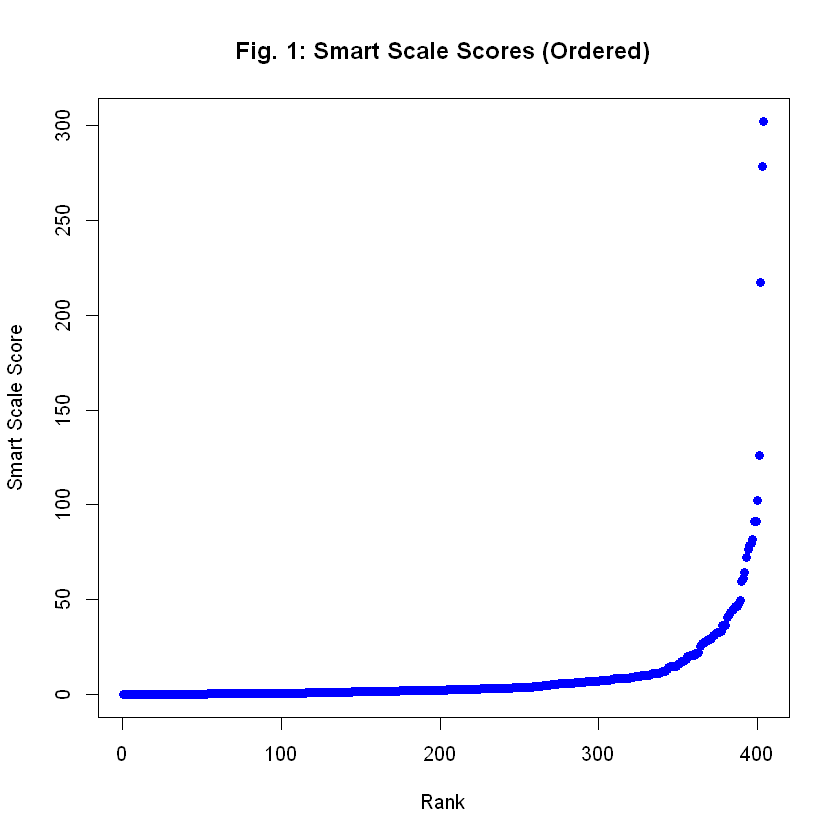

In [162]:
plot(1:length(sort(data$SMART.SCALE.Score)), sort(data$SMART.SCALE.Score), col='blue', pch=16, 
     xlab='Rank', ylab='Smart Scale Score', main='Fig. 1: Smart Scale Scores (Ordered)')

In Fig. 1 above, the SSS's appear to follow a power law, with a long tail on the left and a relatively small number of projects having extreme scores. The distribution of scores clearly does not follow a linear pattern. Accordingly, because only a small number of projects exceed a SSS of 30, we will truncate all subsequent visualizations at 30 to allow the variation in non-outliers to be clearly seen.

### 3.1 Descriptive Statistics for Majority (Lower-Scoring) Projects (SSS < 30)

To drill down further, we look at the distribution of Smart Scale Scores by area type and district. We begin with area type, looking at the number of projects within each of the four area types together with their average smart scale scores:

In [163]:
dt1 <- data.frame(table(data$Area.Type))
m1 <- data.frame(aggregate(data$SMART.SCALE.Score ~ data$Area.Type, FUN=mean))
mm1 <- data.frame(aggregate(data$SMART.SCALE.Score ~ data$Area.Type, FUN=median))
dt1 <- cbind(dt1, m1$data.SMART.SCALE.Score, mm1$data.SMART.SCALE.Score)
colnames(dt1) <- c('Area', 'Num_Projects', 'Mean_Smart_Scale_Score', 'Median_Smart_Scale_Score')
dt1

Area,Num_Projects,Mean_Smart_Scale_Score,Median_Smart_Scale_Score
A,114,16.287246,2.9795
B,88,8.776795,4.3685
C,86,6.257140,1.9760
D,116,7.978250,1.4635


By comparing the mean SSS to the medians, it is apparant that the few high-scoring projects significantly inflate the means. Below we look more closely at the spread of the SSS by area type (truncated at 30, as discussed above):

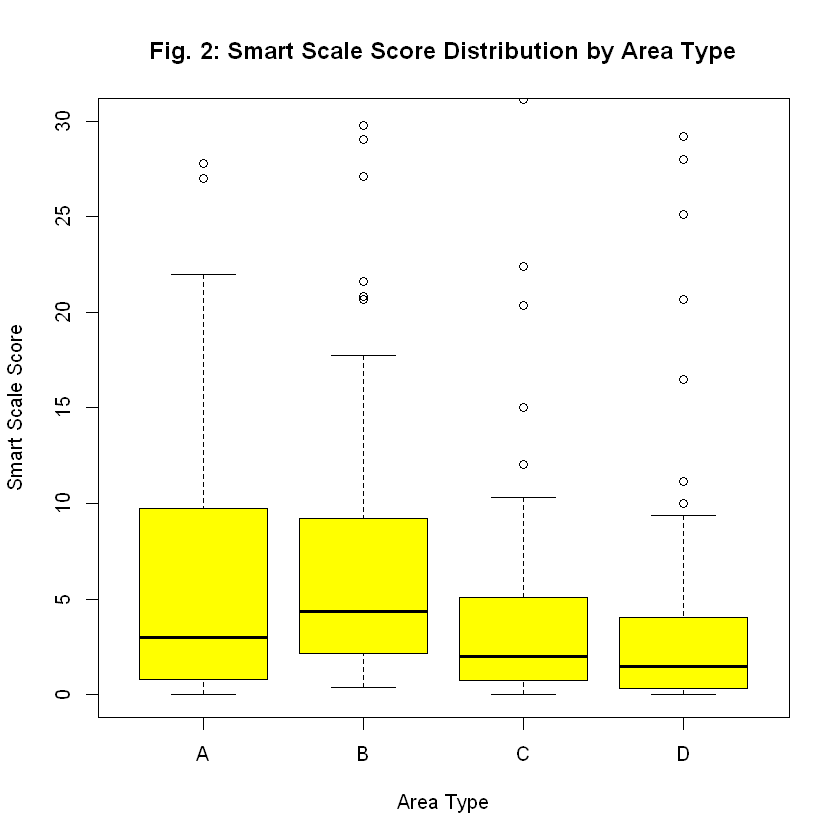

In [164]:
boxplot(SMART.SCALE.Score~Area.Type,data=data, main="Fig. 2: Smart Scale Score Distribution by Area Type",
        xlab="Area Type", ylab="Smart Scale Score", ylim=c(0, 30), col="yellow") 

In Fig. 2 above, area type A has the greatest amount of variance while area type D has the least. Area types C and D have similar distribution profiles, with area type D having the lowest overall median.

Below we shift our perspective to look at SSS with respect to district. We begin with a basic summarization of scores by district:

In [165]:
dt2 <- data.frame(table(data$District))
m2 <- data.frame(aggregate(data$SMART.SCALE.Score ~ data$District, FUN=mean))
mm2 <- data.frame(aggregate(data$SMART.SCALE.Score ~ data$District, FUN=median))
dt2 <- cbind(dt2, m2$data.SMART.SCALE.Score, mm2$data.SMART.SCALE.Score)
colnames(dt2) <- c('District', 'Num_Projects', 'Mean_Smart_Scale_Score', 'Median_Smart_Scale_Score')
dt2

District,Num_Projects,Mean_Smart_Scale_Score,Median_Smart_Scale_Score
Bristol,42,1.160738,0.4695
Culpeper,35,3.597029,2.1690
Fredericksburg,25,8.902320,1.8640
Hampton Roads,52,23.536212,2.0735
Lynchburg,28,9.429893,1.7990
NOVA,58,11.844241,3.3630
Richmond,72,7.878069,3.2880
Salem,50,10.277980,2.5410
Staunton,42,10.463905,2.7075


In a manner similar to above, we see the extreme high-scoring projects inflating the means. In Fig. 3 below the distribution of scores by district is shown.

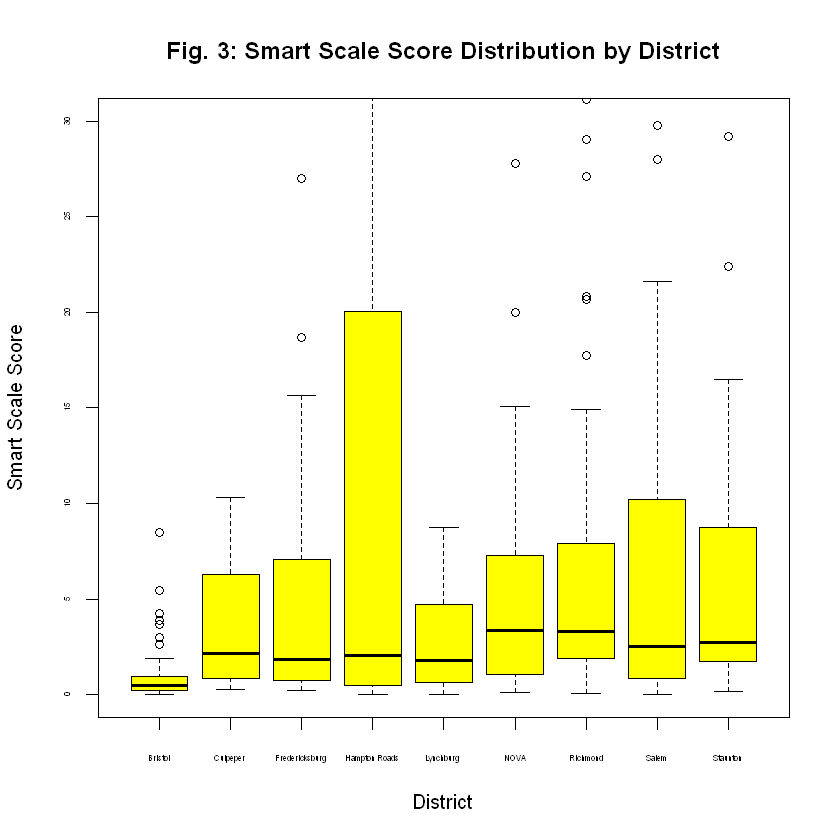

In [166]:
boxplot(SMART.SCALE.Score~District,data=data, main="Fig. 3: Smart Scale Score Distribution by District",
        xlab="District", ylab="Smart Scale Score", ylim=c(0, 30), col="yellow", cex.axis=0.4) 

In Fig. 3 the Hampton Roads district has significantly more variance than all other districts, while NOVA and Richmond have the highest medians scores.

### 3.2 Descriptive Statistics for Minority High-Scoring Projects (SSS > 30)

Up to now the exploration has been focused on the majority of projects which tend toward the lower range of SSS. We turn our attention to the scores falling on the far right of Fig. 1 ranging from 30 and above. We first tabulate the number of projects falling in this range by area type:

In [167]:
high.ss <- subset(data, SMART.SCALE.Score >= 30)
dt3 <- data.frame(table(high.ss$Area.Type))
m3 <- data.frame(aggregate(high.ss$SMART.SCALE.Score ~ high.ss$Area.Type, FUN=mean))
mm3 <- data.frame(aggregate(high.ss$SMART.SCALE.Score ~ high.ss$Area.Type, FUN=median))
dt3 <- cbind(dt3, m3$high.ss.SMART.SCALE.Score, mm3$high.ss.SMART.SCALE.Score)
colnames(dt3) <- c('Area', 'Num_Projects', 'Mean_Smart_Scale_Score', 'Median_Smart_Scale_Score')
dt3

Area,Num_Projects,Mean_Smart_Scale_Score,Median_Smart_Scale_Score
A,13,105.97615,61.1800
B,4,58.23500,47.1480
C,6,47.45583,41.3365
D,10,59.80840,62.2070


We see above that area types A and D have the majority of these high-scoring projects. A similar breakdown by district is shown below.

In [168]:
dt4 <- data.frame(District=unique(data$District))
dt4 <- merge(dt4, data.frame(table(high.ss$District)), by.x='District', by.y='Var1', all.x=TRUE)
m4 <- data.frame(aggregate(high.ss$SMART.SCALE.Score ~ high.ss$District, FUN=mean))
dt4 <- merge(dt4, m4, by.x='District', by.y='high.ss.District', all.x=TRUE)
mm4 <- data.frame(aggregate(high.ss$SMART.SCALE.Score ~ high.ss$District, FUN=median))
dt4 <- merge(dt4, mm4, by.x='District', by.y='high.ss.District', all.x=TRUE)
colnames(dt4) <- c('District', 'Num_Projects', 'Mean_Smart_Scale_Score', 'Median_Smart_Scale_Score')
dt4

District,Num_Projects,Mean_Smart_Scale_Score,Median_Smart_Scale_Score
Bristol,0,NA,NA
Culpeper,0,NA,NA
Fredericksburg,2,57.72750,57.7275
Hampton Roads,11,95.42873,59.8350
Lynchburg,3,67.47600,79.6260
NOVA,4,108.68375,86.2600
Richmond,4,50.86100,40.4150
Salem,4,58.85550,48.1505
Staunton,5,50.44980,42.0710


Because there are so few projects at this score range, we will omit further drill-down to look at actual score distributions.

## IV. Examination of Scoring Consistency

An important aspect of this analysis is to see if the scoring methodology as specified in the technical guide was applied consistently to the projects. As previously discussed, in the technical guide (Table 4.2, p. 36) there are six major factors used to compute the Smart Scale score which are themselves calculated from more basic measurements:

* Congestion Mitigation
* Economic Development
* Accessibility
* Safety
* Environmental Quality
* Land Use

Of these six factors only Land Use is directly given in the dataset. All other major metrics are calculated from their basic constituent measurements as specified on pages 27-31. Within the data there are four area types: A, B, C, and D. Each of these area types has a unique factor weighting that results in its Smart Scale Score. These weightings are specified for each area in Table 4.2 on page 36 within the technical guide. It is noted that for areas C and D, the Land Use factor is not used (or equivalently, carries 0% weight).

The examination of scoring consistency will be done in two parts. First, the SSS will be independently calculated according to the specifications in the technical guide. These independently-calculated smart scale scores will then be compared to the scores provided in the dataset, and the deviations will be examined. In the second part, the best-fit factor weightings will be determined using constrained linear regression and compared to what is specified in the technical guide. Finally, an assessment as to whether the evidence suggests consistent or inconsistent scoring will be made.

### 4.1 Comparing Assigned Smart Scale Scores to Scores Calculated According to the Technical Guide

Pages 37-40 of the technical guide specify how to calculate the final smart scale score, and in this section we implement these calculations to in an attempt to replicate the assigned Smart Scale Scores. In the dataset all basic measurements needed for each factor weight calculation is present except for those pertaining to the Land Use factor. Instead, a Land Use factor score is provided. The final Smart Scale score is determined by a weighted average of the six factors, and these weightings differ depending on which area type the project falls within. All steps in the calcuation process are summarized in Table 4.6 on p. 40.

#### 4.1.1 Replicating the Technical Guide Calculations on the Data

The Smart Scale Score calculations specified technical guide are replicated on the dataset below:

In [169]:
#------ Step 1: Normalization of Measure Weights
measure.cols <- c('Throughput.Score', 'Delay.Score',
                  'Econ.Dev.Support.Score', 'Intermodal.Access.Score', 'Travel.Time.Reliability.Score',
                  'Access.to.Jobs', 'Disadvantaged.Access.to.Jobs', 'Multimodal.Access.Score',
                  'Crash.Frequency.Score', 'Crash.Rate.Score',
                  'Air.Quality.Score', 'Enviro.Impact.Score')
for(i in measure.cols) {data[[i]] <- 100 * data[[i]] / max(data[[i]])}

#------ Step 2: Apply Measure Weights
# For a given data frame, a set of weights, and a set of selected columns, this function returns a new
# vector corresponding to the weighted averages of the columns.
weighted.column.average <- function(data.frame, weight.vec, selected.columns) {
  v <- 0 
  for(i in 1:length(weight.vec)) {
    v <- v + (weight.vec[i] * data.frame[[selected.columns[i]]])
  }
  v
}

# Calculate the composite factor scores (except Land Use, which is APPARENTLY already given in the data) from 
# component scores according to the Smart Scale November 2017 technical guide, p. 40.
data$Congestion.Score <- weighted.column.average(data, c(0.5, 0.5), c('Throughput.Score', 'Delay.Score'))
data$Economic.Score <- weighted.column.average(data, c(0.6, 0.2, 0.2), c('Econ.Dev.Support.Score', 'Intermodal.Access.Score', 'Travel.Time.Reliability.Score'))
data$Accessibility.Score <- weighted.column.average(data, c(0.6, 0.2, 0.2), c('Access.to.Jobs', 'Disadvantaged.Access.to.Jobs', 'Multimodal.Access.Score'))
data$Safety.Score <- weighted.column.average(data, c(0.5, 0.5), c('Crash.Frequency.Score', 'Crash.Rate.Score'))
data$Environmental.Score <- weighted.column.average(data, c(0.5, 0.5), c('Air.Quality.Score', 'Enviro.Impact.Score'))
# Land use score already in data - no component scores listed.

#------ Step 3: Apply Factor Weights
# Given a dataframe with calculated factor scores, this function computes the project value according to 
# Table 4.2, p.36 of the technical guide.
calc.proj.value <- function(dataset) {
  factor.cols.ab <- c('Congestion.Score', 'Economic.Score', 'Accessibility.Score', 'Safety.Score',
                      'Environmental.Score', 'Land.Use.Score')
  factor.cols.cd <- c('Congestion.Score', 'Economic.Score', 'Accessibility.Score', 'Safety.Score',
                      'Environmental.Score')
  sa <- weighted.column.average(dataset, c(0.45, 0.5, 0.15, 0.5, 0.1, 0.2), factor.cols.ab)
  sb <- weighted.column.average(dataset, c(0.15, 0.2, 0.25, 0.2, 0.1, 0.1), factor.cols.ab)
  sc <- weighted.column.average(dataset, c(0.15, 0.25, 0.25, 0.25, 0.1), factor.cols.cd)
  sd <- weighted.column.average(dataset, c(0.10, 0.35, 0.15, 0.3, 0.1), factor.cols.cd)
  scores <- c()
  for(i in 1:nrow(dataset)) {
    if(dataset[i, 'Area.Type'] == 'A') {scores[i] <- sa[i]}
    else if(dataset[i, 'Area.Type'] == 'B') {scores[i] <- sb[i]}
    else if(dataset[i, 'Area.Type'] == 'C') {scores[i] <- sc[i]}
    else {scores[i] <- sd[i]}
  }
  scores
}

# Add a new column to data with our calculated project benefit scores.
data['Calc.Project.Benefit.Score'] <- calc.proj.value(data)

#------ Step 4: Apply Factor Weights  
data['Calc.SMART.SCALE.Score'] <- 1e7 * data[['Calc.Project.Benefit.Score']] / data[['SMART.SCALE.Request']] 


#### 4.1.2 Comparing the Calculated versus Assigned Smart Scale Scores

In order to assess the whether the calculation methodology as specified in the technical guide was applied consistently across the projects, we will use a linear regression model that predicts the actual SSS from the calculated SSS. If the two scores are consistent across the projects then they will fall perrfectly along the line of best fit. Since the factor weightings differ across area type, we visualize the fit for each of the four area types below.

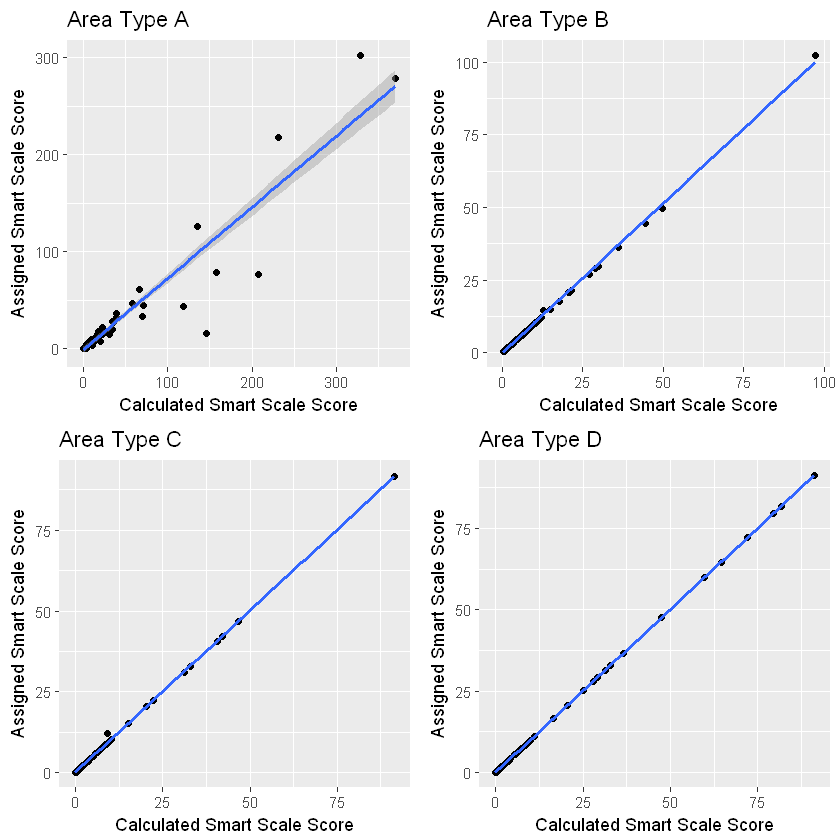

In [170]:
# Given a dataset this function builds a scatterplot with the linear regression trend line.
ss.scatter.plot <- function(dataset, title='Calculated vs. Assigned Smart Scale Scores') {
  ggplot(data=dataset,
         aes(x=Calc.SMART.SCALE.Score, y=SMART.SCALE.Score)) +
    geom_point() + 
    geom_smooth(method=lm) +
    labs(x='Calculated Smart Scale Score', y='Assigned Smart Scale Score', 
         title=title)
}

# Build plots for each of the four area types.
sp.a <- ss.scatter.plot(subset(data, Area.Type == 'A'), 'Area Type A')
sp.b <- ss.scatter.plot(subset(data, Area.Type == 'B'), 'Area Type B')
sp.c <- ss.scatter.plot(subset(data, Area.Type == 'C'), 'Area Type C')
sp.d <- ss.scatter.plot(subset(data, Area.Type == 'D'), 'Area Type D')

# Display the four plots within a single grid.
grid.arrange(sp.a, sp.b, sp.c, sp.d, nrow=2) 

It is readily apparant from these visualizations that the Smart Scale methodology was applied consistently, with the notable exception for a set of projects within the A area type. We look below at the specific projects which had a >40% difference in assigned versus calculated SSS.

#### 4.1.3 Projects with Large Assigned Calculated Smart Scale Score Differences

We list those projects below having differences of at least 40% between their calculated and assigned SSS. We further filter out projects whose calculated SSS is below 1.

In [158]:
data$SMART.SCALE.Diff.Percent <- round((100 * (data$Calc.SMART.SCALE.Score - data$SMART.SCALE.Score) / 
                                        data$Calc.SMART.SCALE.Score), 2)
sig.diffs <- subset(data, Calc.SMART.SCALE.Score > 1 & abs(SMART.SCALE.Diff.Percent) > 40)
sig.diffs[c('App.Id', 'Area.Type', 'District', 'Project.Title', 'Calc.SMART.SCALE.Score', 
            'SMART.SCALE.Score', 'SMART.SCALE.Diff.Percent')]

,App.Id,Area.Type,District,Project.Title,Calc.SMART.SCALE.Score,SMART.SCALE.Score,SMART.SCALE.Diff.Percent
1,1414,A,NOVA,VRE Fredericksburg Line Capacity Expansion,12.422545,6.934,44.18
10,1141,A,Fredericksburg,Lafayette Blvd and Harrison Road,69.982690,33.516,52.11
16,1216,A,NOVA,Prentice Drive Extension (Shellhorn Road to Lockridge Road),6.224782,3.397,45.43
32,1299,A,NOVA,Route 1/Jeff Davis Widening from Cardinal/Neabsco to Rte 234,1.422909,0.737,48.20
35,1115,A,NOVA,Richmond Highway Widening (Mt Vernon Hwy to Napper Rd),3.210573,1.479,53.93
38,1453,A,Hampton Roads,Skiffes Creek Connector,157.569800,78.768,50.01
41,1126,A,NOVA,Evergreen Mills Road (Northstar Blvd to Loudoun County Pkwy),6.699072,2.906,56.62
54,1497,A,Hampton Roads,Hampton Boulevard and Terminal Boulevard Grade Separation,1.283302,0.578,54.96
65,1138,A,Fredericksburg,Route 208 and Breckenridge Drive Intersection Improvements,146.055573,15.659,89.28
71,1296,A,NOVA,Route 234 Bypass at Dumfries/PWP/Brentsville Rd Interchange,1.620574,0.801,50.57
